<a href="https://colab.research.google.com/github/SamBitSync/CogSci_NeuroAI/blob/main/MBM_2025_tutorial_Toy_polysomnography_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Sleep stage classification from polysomnography (PSG) data

<div class="alert alert-info"><h4>Note</h4><p>This code is taken from the analysis code used in
          `ChambonEtAl2018`. If you reuse this code please consider
          citing this work.</p></div>

This tutorial explains how to perform a toy polysomnography analysis that
answers the following question:

 Given two subjects from the Sleep Physionet dataset
               `KempEtAl2000,GoldbergerEtAl2000`, namely
               *Alice* and *Bob*, how well can we predict the sleep stages of
               *Bob* from *Alice's* data?

This problem is tackled as supervised multiclass classification task. The aim
is to predict the sleep stage from 5 possible stages for each chunk of 30
seconds of data.



The code is adapted from the work of Alexandre Gramfort, Stanislas Chambon, and Joan Massich, originally licensed under BSD-3-Clause, and edited by Suvadeep Maiti for the **Minds Brains & Machines workshop** held from 12th to 16th May 2025 at Krea University.



In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

import mne
from mne.datasets.sleep_physionet.age import fetch_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Load the data

Here we download the data of two subjects. The end goal is to obtain
`epochs` and the associated ground truth.

MNE-Python provides us with
[`mne.datasets.sleep_physionet.age.fetch_data`](https://mne.tools/stable/generated/mne.datasets.sleep_physionet.age.fetch_data.html#mne.datasets.sleep_physionet.age.fetch_data) to conveniently download
data from the Sleep Physionet dataset
`KempEtAl2000,GoldbergerEtAl2000`.
Given a list of subjects and records, the fetcher downloads the data and
provides us with a pair of files for each subject:

* ``-PSG.edf`` containing the polysomnography. The `raw` data from the
  EEG helmet,
* ``-Hypnogram.edf`` containing the `annotations` recorded by an
  expert.

Combining these two in a `mne.io.Raw` object will allow us to extract
`events` based on the descriptions of the annotations to obtain the
`epochs`.

### Read the PSG data and Hypnograms to create a raw object


In [ ]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(
    alice_files[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error",  # ignore issues with stored filter settings
)
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating /root/mne_data


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 6.49GB/s]
100%|██████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 471kB/s]
100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 39.7GB/s]
100%|█████████████████████████████████████| 3.90k/3.90k [00:00<00:00, 3.14MB/s]

Download complete in 03m34s (94.8 MB)


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MiB, data loaded>

## Data Exploration

In [ ]:
# Display a brief summary of the loaded data
print(raw_train)
print("Annotations:", raw_train.annotations.description[:10])  # Show first 10 annotation types

<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MiB, data loaded>
Annotations: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3'
 'Sleep stage 2' 'Sleep stage 3' 'Sleep stage 4' 'Sleep stage 3'
 'Sleep stage 4' 'Sleep stage 3']


Using matplotlib as 2D backend.


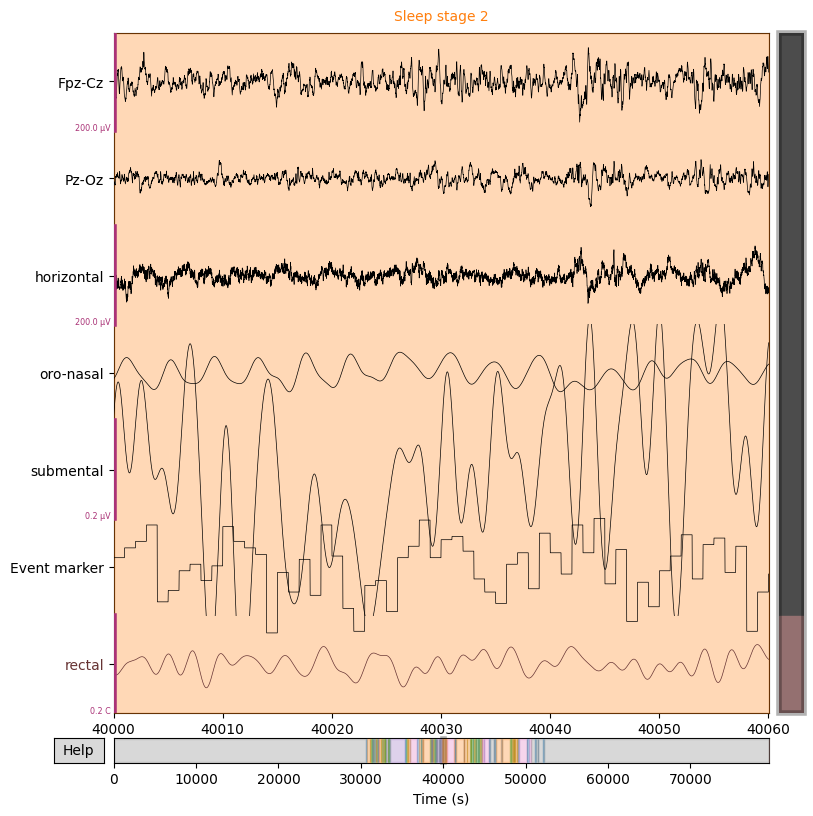

In [ ]:
# ------------------------------
# Visualize raw signals from different sensor types
# ------------------------------
# Plot a 60-second window of the raw data starting at 60 seconds.
# Scaling factors are chosen manually for better visualization of EEG, EOG, EMG, etc.
raw_train.plot(
    start=40000,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
    title='Raw signals from different sensors (60s window)',
    show=True
);



In [ ]:
# ------------------------------
# Explore the channels and their types
# ------------------------------
print(f"Number of channels: {len(raw_train.ch_names)}")
print("Channel names:", raw_train.ch_names)

# Let's separate channels by their types to understand the data better
channel_types = raw_train.get_channel_types()
print("Channel types distribution:")
from collections import Counter
print(Counter(channel_types))


Number of channels: 7
Channel names: ['Fpz-Cz', 'Pz-Oz', 'horizontal', 'oro-nasal', 'submental', 'rectal', 'Event marker']
Channel types distribution:
Counter({'eeg': 2, 'eog': 1, 'resp': 1, 'emg': 1, 'temperature': 1, 'stim': 1})


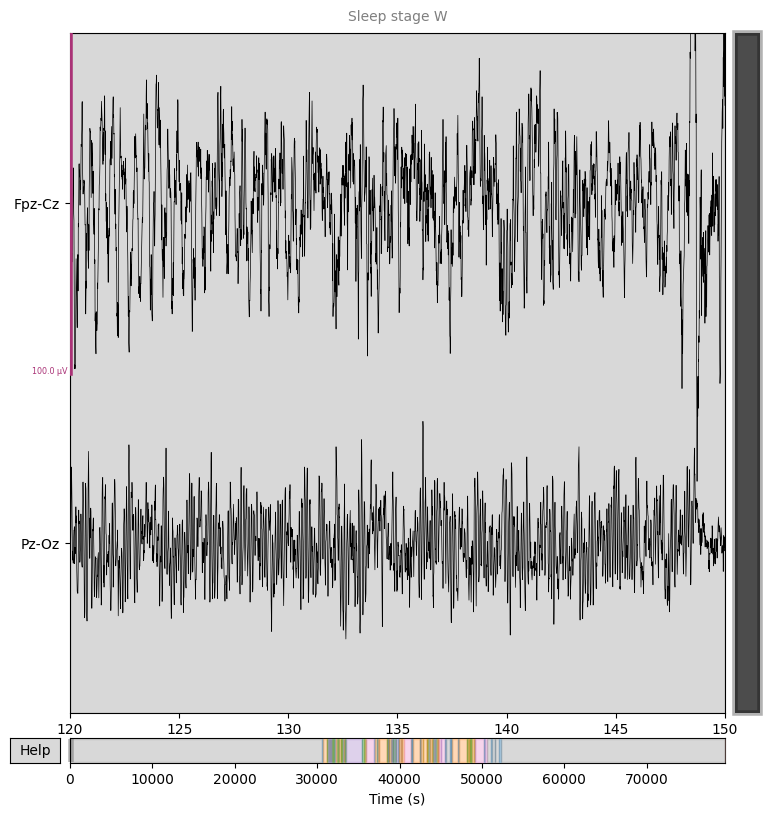

In [ ]:
# ------------------------------
# Plot EEG channels separately with bigger vertical scaling
# ------------------------------


eeg_picks = mne.pick_types(raw_train.info, eeg=True, exclude='bads')

raw_train.plot(
    start=120,
    duration=30,
    picks=eeg_picks,
    scalings=dict(eeg=5e-5),
    title='EEG Channels (30s segment)',
    show_scrollbars=True,
    block=True
);


Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


<ipython-input-8-9831e7dcd48a>:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psds.plot(show=True)


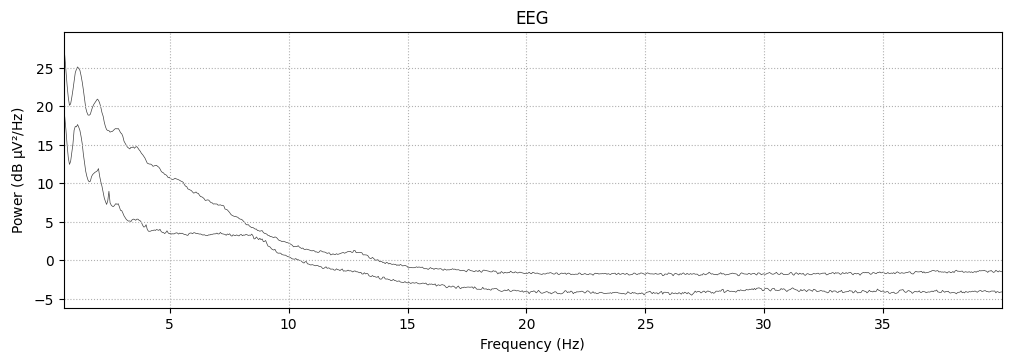

In [ ]:
# ------------------------------
# Frequency content of EEG signals using PSD (corrected)
# ------------------------------

# Compute the power spectral density (PSD) for EEG channels
psds = raw_train.compute_psd(
    fmin=0.5,   # Minimum frequency to analyze
    fmax=40,    # Maximum frequency to analyze
    picks=eeg_picks,
    average='mean',  # Average PSD across segments using mean
)

# Plot the computed PSD
fig = psds.plot(show=True)


### Focus on EEG signals during a specific sleep stage

Let's isolate a 30-second segment labeled 'Sleep stage 2' (N2) and visualize the EEG channels during this stage.  
Observe the EEG activity pattern in this stage compared to other stages.


In [ ]:
# n2_annotations = [annot for annot in raw_train.annotations if annot['description'] == 'Sleep stage 2']
# first_n2 = n2_annotations[0]
# start = first_n2['onset']
# duration = first_n2['duration']

# print(f"Plotting EEG data from Sleep stage 2 epoch starting at {start}s")

# epoch_n2 = raw_train.copy().crop(tmin=start, tmax=start+duration)

# eeg_picks = mne.pick_types(epoch_n2.info, eeg=True)
# epoch_n2.plot(start=0, duration=duration, picks=eeg_picks, scalings=dict(eeg=5e-5), title='Sleep stage 2 EEG segment', block=True);


### Visualizing the Sleep Hypnogram

A hypnogram is a graphical representation of sleep stages over time.  
Here, we extract sleep stage annotations and plot them against time to show how the subject cycles through sleep stages during the recording.


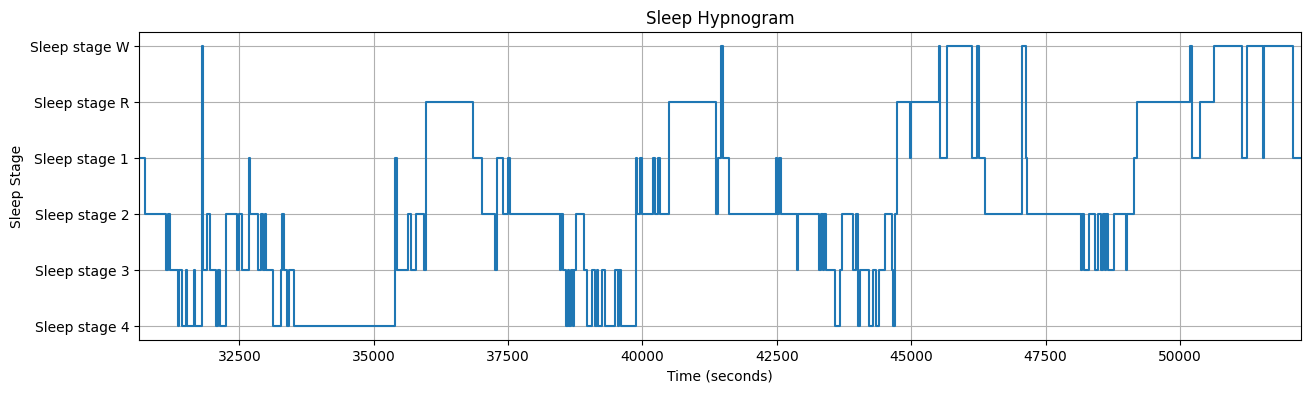

In [ ]:
# Allowed sleep stages
allowed_stages = {'Sleep stage W', 'Sleep stage R', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4'}

# Filter annotations to keep only allowed stages
filtered_annots = [(onset, duration, desc) for onset, duration, desc
                   in zip(raw_train.annotations.onset, raw_train.annotations.duration, raw_train.annotations.description)
                   if desc in allowed_stages]

# Find first and last non-Wake indices
first_sleep_idx = next(i for i, (_, _, desc) in enumerate(filtered_annots) if desc != 'Sleep stage W')
last_sleep_idx = len(filtered_annots) - 1 - next(i for i, (_, _, desc) in enumerate(reversed(filtered_annots)) if desc != 'Sleep stage W')

# Crop annotations to sleep period
cropped_annots = filtered_annots[first_sleep_idx:last_sleep_idx+1]

# Extract data
onsets, durations, stages = zip(*cropped_annots)

# Put 'Sleep stage W' at top (0), rest follow in order
unique_stages = ['Sleep stage W', 'Sleep stage R', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4']
stage_to_num = {stage: i for i, stage in enumerate(unique_stages)}

# Prepare arrays for step plot
times = []
stage_codes = []

for onset, duration, stage in zip(onsets, durations, stages):
    times.extend([onset, onset + duration])
    stage_codes.extend([stage_to_num[stage], stage_to_num[stage]])

# Reverse y-axis ticks so W is at the top
plt.figure(figsize=(15, 4))
plt.step(times, stage_codes, where='post')
plt.yticks(ticks=range(len(unique_stages)), labels=unique_stages)
plt.gca().invert_yaxis()  # Invert y-axis to have W at the top
plt.xlabel('Time (seconds)')
plt.ylabel('Sleep Stage')
plt.title('Sleep Hypnogram')
plt.xlim(onsets[0], onsets[-1] + durations[-1])
plt.grid(True)
plt.show()


### Extract 30s events from annotations

The Sleep Physionet dataset is annotated using
[8 labels](physionet_labels_):
Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 corresponding to the range from
light sleep to deep sleep, REM sleep (R) where REM is the abbreviation for
Rapid Eye Movement sleep, movement (M), and Stage (?) for any none scored
segment.

We will work only with 5 stages: Wake (W), Stage 1, Stage 2, Stage 3/4, and
REM sleep (R). To do so, we use the ``event_id`` parameter in
:func:`mne.events_from_annotations` to select which events are we
interested in and we associate an event identifier to each of them.

Moreover, the recordings contain long awake (W) regions before and after each
night. To limit the impact of class imbalance, we trim each recording by only
keeping 30 minutes of wake time before the first occurrence and 30 minutes
after the last occurrence of sleep stages.


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


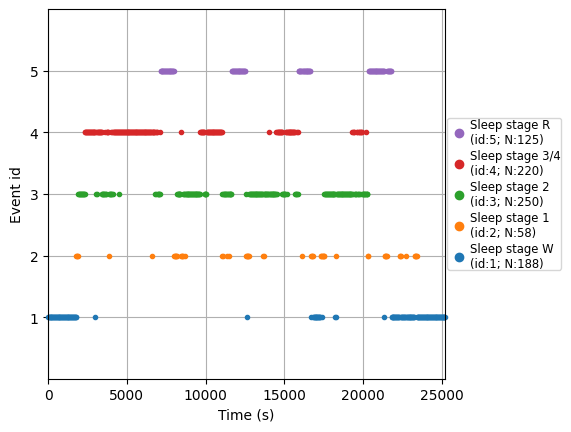

In [ ]:
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]["onset"] - 30 * 60, annot_train[-2]["onset"] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

# create a new event_id that unifies stages 3 and 4
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

# plot events
fig = mne.viz.plot_events(
    events_train,
    event_id=event_id,
    sfreq=raw_train.info["sfreq"],
    first_samp=events_train[0, 0],
)

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Create Epochs from the data based on the events found in the annotations

This code extracts 30-second epochs from the raw data based on sleep stage events. It creates an Epochs object for analysis, then deletes the raw data to save memory.


In [ ]:
tmax = 30.0 - 1.0 / raw_train.info["sfreq"]  # tmax in included

epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_train

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs | 841 events (good & bad), 0 – 29.99 s (baseline off), ~11 KiB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


# Applying the same steps to the test data from Bob



In [ ]:
raw_test = mne.io.read_raw_edf(
    bob_files[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error",
)
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]["onset"] - 30 * 60, annot_test[-2]["onset"] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)
epochs_test = mne.Epochs(
    raw=raw_test,
    events=events_test,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_test

print(epochs_test)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs | 1103 events (good & bad), 0 – 29.99 s (baseline off), ~11 KiB, data not loaded,
 'Sleep stage W': 157
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170>


# Feature Engineering

Observing the power spectral density (PSD) plot of the `epochs` grouped
by sleeping stage we can see that different sleep stages have different
signatures. These signatures remain similar between Alice and Bob's data.

The rest of this section we will create EEG features based on relative power
in specific frequency bands to capture this difference between the sleep
stages in our data.



Using data from preloaded Raw for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data fr

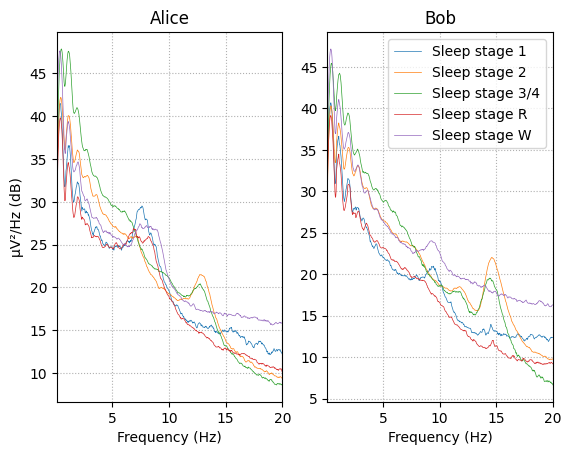

In [ ]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2], ["Alice", "Bob"], [epochs_train, epochs_test]):
    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.0)
        spectrum.plot(
            ci=None,
            color=color,
            axes=ax,
            show=False,
            average=True,
            amplitude=False,
            spatial_colors=False,
            picks="data",
            exclude="bads",
        )
    ax.set(title=title, xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)

### Design a scikit-learn transformer from a Python function

We will now create a function to extract EEG features based on relative power
in specific frequency bands to be able to predict sleep stages from EEG
signals.



In [ ]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

## Multiclass classification workflow using scikit-learn

To answer the question of how well can we predict the sleep stages of Bob
from Alice's data and avoid as much boilerplate code as possible, we will
take advantage of two key features of sckit-learn: `Pipeline`_ , and
`FunctionTransformer`_.

Scikit-learn pipeline composes an estimator as a sequence of transforms
and a final estimator, while the FunctionTransformer converts a python
function in an estimator compatible object. In this manner we can create
scikit-learn estimator that takes `mne.Epochs` thanks to
``eeg_power_band`` function we just created.



In [ ]:
pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {acc}")

Using data from preloaded Raw for 841 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1103 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6727107887579329


In short, yes. We can predict Bob's sleeping stages based on Alice's data.

### Further analysis of the data

We can check the confusion matrix or the classification report.



In [ ]:
print(confusion_matrix(y_test, y_pred))

[[153   1   1   2   0]
 [ 71  26   8   0   4]
 [ 50  36 429  24  23]
 [  0   0   3 102   0]
 [ 51  70  17   0  32]]


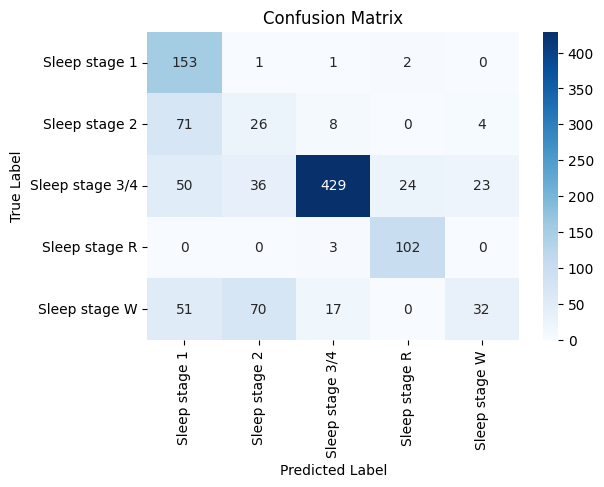

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap using seaborn for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=stages, yticklabels=stages)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.47      0.97      0.63       157
  Sleep stage 1       0.20      0.24      0.21       109
  Sleep stage 2       0.94      0.76      0.84       562
Sleep stage 3/4       0.80      0.97      0.88       105
  Sleep stage R       0.54      0.19      0.28       170

       accuracy                           0.67      1103
      macro avg       0.59      0.63      0.57      1103
   weighted avg       0.72      0.67      0.67      1103



## Exercise

Fetch 50 subjects from the Physionet database and run a 5-fold
cross-validation leaving each time 10 subjects out in the test set.

